In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
# PINN 모델 정의
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 3)
        )


    def forward(self, x, y):
        input_data = torch.stack([x.view(-1), y.view(-1)], dim=1)
        return self.model(input_data)

In [3]:
# 모델 생성 및 학습 
model = PINN().cuda()
model.load_state_dict(torch.load("model/Cylinder_Re20.pt"))

<All keys matched successfully>

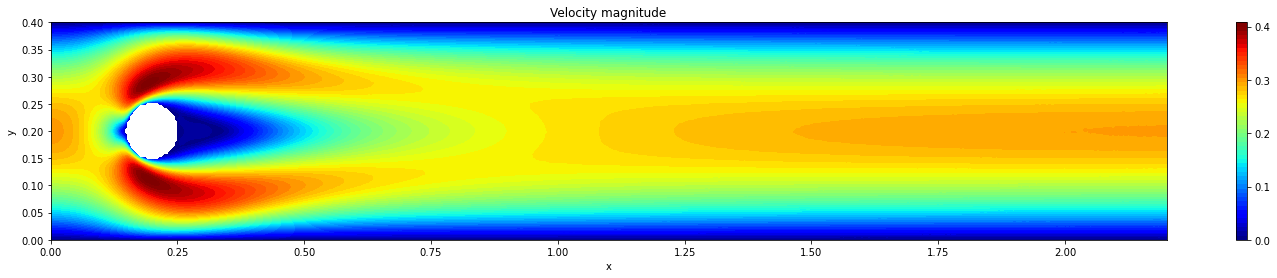

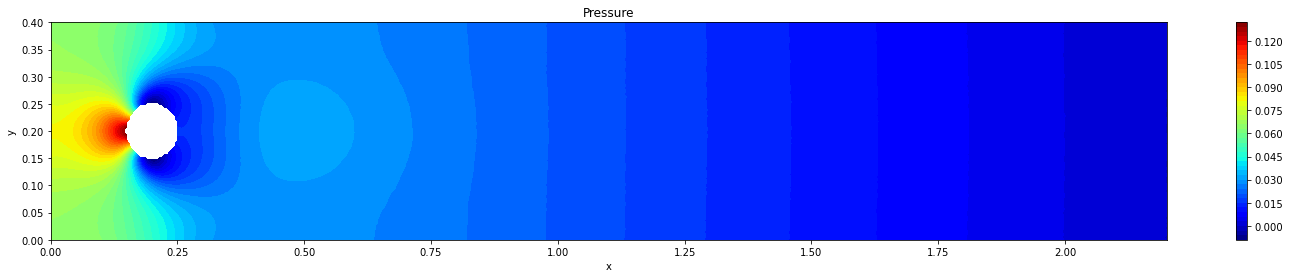

In [4]:
# 학습 데이터 생성 
x_initial = np.linspace(0, 2.2, 440).reshape(-1, 1)
y_initial = np.linspace(0, 0.4, 80).reshape(-1, 1)
x_initial, y_initial = np.meshgrid(x_initial, y_initial)
x_initial_tensor = torch.tensor(x_initial, device="cuda", dtype=torch.float32)
y_initial_tensor = torch.tensor(y_initial, device="cuda", dtype=torch.float32)


u = model(x_initial_tensor, y_initial_tensor)[:,0].detach().cpu().numpy()
v = model(x_initial_tensor, y_initial_tensor)[:,1].detach().cpu().numpy()
p = model(x_initial_tensor, y_initial_tensor)[:,2].detach().cpu().numpy()
vel = (u*u+v*v)**(1/2)


# 구멍을 뚫은 부분 제외한 데이터 마스킹
cylinder_mask = (x_initial-0.2)**2 + (y_initial-0.2)**2 > 0.05**2


# 속도(velocity) 데이터에 대한 등고선 그래프 그리기
fig, ax = plt.subplots(figsize=(25, 4))
masked_vel = np.where(cylinder_mask, vel.reshape(80,440), np.nan)
contourf = ax.contourf(x_initial, y_initial, masked_vel, cmap='jet', levels=51, vmax=0.4, vmin=0)
colorbar = plt.colorbar(contourf, ax=ax, ticks = [0,0.1,0.2,0.3,0.4])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Velocity magnitude')
plt.show()

# 그래프 생성
fig, ax = plt.subplots(figsize=(25, 4))
masked_p = np.where(cylinder_mask, p.reshape(80,440), np.nan)
scatter = ax.contourf(x_initial, y_initial, masked_p, cmap='jet', levels=51)
colorbar = plt.colorbar(scatter, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Pressure')
plt.show()
